This is a data processing script. Converts the image files into 3D Tensors and expression value as an int between 0 and 10. Can feed into pytorch dataloader for shuffling and creating batches. Using manually annotated list of folders for processing on small set of data. Can remove the requirement inFolder when getting all data. 

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torchvision.models as models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


This reads in the csv and splits it to get list of folders from Pandas dataframe. This is needed if we are only making a small dataset of specific folders. Ignore if using full dataset listed in excel document. Because we are using manually annotated data only, this is a necessary step. 

In [2]:
training_sheet = pd.read_csv('training.csv')
training_sheet_split = pd.DataFrame(training_sheet.subDirectory_filePath.str.split("/").tolist(),columns = ['folder','subpath'])
folders = list(map(int,training_sheet_split.folder))
folder_list = [1,10,100, 102] + list(range(1000,1029))
inFolder = np.isin(folders, folder_list)
folder_list_val = [1029]
inFolder_val = np.isin(folders, folder_list_val)
#print(np.where(inFolder)[0])

Creating dataset class that reads in csv, transforms, and included folders of images. The length function gives an accurate size, and the getitem allows retrieval of 3D tensor of image plus expression as an int. This is returned as a tuple when indexing through the dataset object. 

In [3]:
class FaceDataset(Dataset):
    """Face dataset."""

    def __init__(self, csv_file, root_dir, transform=None, inFolder=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.training_sheet = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        if inFolder.any() == None:
            self.inFolder = np.full((len(self.training_sheet),), True)
        
        self.loc_list = np.where(inFolder)[0]
        

    def __len__(self):
        return  np.sum(inFolder*1)

    def __getitem__(self, idx):
        idx = self.loc_list[idx] 
        emotion = self.training_sheet.iloc[idx,6]
        img_name = os.path.join(self.root_dir,
                                self.training_sheet.iloc[idx, 0])
        
        image = Image.open(img_name)
        sample = image
        
        if self.transform:
            sample = self.transform(sample)
        
        return {'image': sample, 'emotion': emotion}

This loads the dataset with resizing, random cropping, and transforming to a tensor. Info can be found here. 
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

There is also separation of training and val set. 

In [4]:
face_dataset = FaceDataset(csv_file='training.csv',
                                    root_dir='Manually_Annotated_Images', transform=transforms.Compose([
                                        transforms.Resize(256), transforms.RandomCrop(size=224), transforms.ToTensor()
                                    ]), inFolder = inFolder)

face_dataset_val = FaceDataset(csv_file='training.csv',
                                    root_dir='Manually_Annotated_Images', transform=transforms.Compose([
                                        transforms.Resize(256), transforms.RandomCrop(size=224), transforms.ToTensor()
                                    ]), inFolder = inFolder_val)

dataloader = DataLoader(face_dataset, batch_size=100,
                        shuffle=True)
                                  
    

Testing of the image through a simle imshow on the transformed tensor


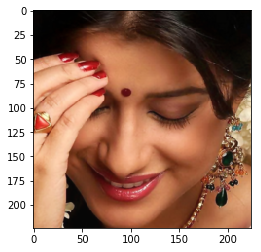

In [5]:
# Testing

sample = face_dataset[3]
im, y = sample['image'], sample['emotion']
im_arr = im.numpy()
im_arr.shape
im_arr = im_arr.transpose(1,2,0)
plt.imshow(im_arr)

In [6]:
dataloader = DataLoader(face_dataset, batch_size=100,
                        shuffle=True)

dataloader_val = DataLoader(face_dataset_val, batch_size=100,
                        shuffle=True)

loaders = {'train': dataloader, 'val': dataloader_val}


In [7]:
#Some Testing

'''
for i_batch, i_sample in enumerate(dataloader):
    if i_batch == 0:
        print(i_sample)
        print(i_sample['image'].size())
        print(i_sample['emotion'].shape)
    print(str(i_batch) + ' out of ' + str(len(face_dataset)/100))
'''


"\nfor i_batch, i_sample in enumerate(dataloader):\n    if i_batch == 0:\n        print(i_sample)\n        print(i_sample['image'].size())\n        print(i_sample['emotion'].shape)\n    print(str(i_batch) + ' out of ' + str(len(face_dataset)/100))\n"

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F 


use_gpu = torch.cuda.is_available()
dataset_size = {'train': len(face_dataset), 'val': len(face_dataset_val)}

def model_training(model, criterion, optimizer, num_epochs):
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('epoch ' + str(epoch) + '/' + str(num_epochs-1))
        
        for settype in ['train', 'val']:
            if settype == 'train':
                model.train(True)
            else:
                model.train(False)
            
            total_loss = 0
            num_correct = 0
            
            for batch_i, data_i in enumerate(loaders[settype]):
                
                data, emotions = data_i['image'], data_i['emotion']
                
                if settype == 'train':
                    if use_gpu:
                        inputs, correct_labels = Variable(data.cuda()), Variable(emotions.cuda())
                    else:
                        inputs, correct_labels = Variable(data), Variable(emotions)
                    optimizer.zero_grad()
                    scores = model(inputs)
                elif settype == 'val':
                    if use_gpu:
                        inputs, correct_labels = Variable(data.cuda()), Variable(emotions.cuda())
                    else:
                        inputs, correct_labels = Variable(data), Variable(emotions)                                       
                    scores = model(inputs)

                _, preds = torch.max(scores.data, 1)
                loss = criterion(scores, emotions)
                
                if settype == 'train':
                    loss.backward()
                    optimizer.step()
                    print('batch ' + str(batch_i) + '/' + str(np.floor(dataset_size[settype]/100)))

                total_loss += loss
                num_correct += torch.sum(preds == emotions.data)
                
            epoch_loss = total_loss / dataset_size[settype]
            epoch_acc = num_correct / dataset_size[settype]
            
            print('epoch loss = ' + str(epoch_loss))
            print('epoch acc = ' + str(epoch_acc))
            
            if settype == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()


In [12]:
model = models.alexnet(num_classes=11)
if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model_training(model, criterion, optimizer, num_epochs=20)

epoch 0/19
batch 0/174.0
batch 1/174.0
batch 2/174.0
batch 3/174.0
batch 4/174.0
batch 5/174.0
batch 6/174.0
batch 7/174.0
batch 8/174.0
batch 9/174.0
batch 10/174.0
batch 11/174.0
batch 12/174.0
batch 13/174.0
batch 14/174.0
batch 15/174.0
batch 16/174.0
batch 17/174.0
batch 18/174.0
batch 19/174.0


KeyboardInterrupt: 